# Fama-French Research and Momentum Factors

- HML, SMB, Mom and ST_Rev
- CRSP, Compustat, Wharton Research Data Services

Terence Lim



## Open connectors to databases and datasets

In [1]:
    import numpy as np
    import pandas as pd
    from pandas import DataFrame, Series
    import matplotlib.pyplot as plt
    import time
    from settings import settings
    import os
    from finds.database import SQL, Redis
    from finds.busday import BusDay
    from finds.structured import PSTAT, CRSP, Benchmarks, Signals
    from finds.backtesting import BackTest
    from finds.solve import fractiles
    LAST_DATE = settings['crsp_date']

    sql = SQL(**settings['sql'])
    user = SQL(**settings['user'])
    rdb = Redis(**settings['redis'])
    bd = BusDay(sql)
    pstat = PSTAT(sql, bd)
    crsp = CRSP(sql, bd, rdb)
    bench = Benchmarks(sql, bd)
    signals = Signals(user)
    LAST_DATE = 20201231
    backtest = BackTest(user, bench, 'RF', LAST_DATE)
    logdir = os.path.join(settings['images'], 'ff')  # None 

## Construct HML

- Load items from Compustat Annual
- Construct HML as shareholders equity plus investment tax credits, less preferred stock divided by December market cap.
- Require 6 month reporting lag and at least two years history in Compustat

In [2]:
    label = 'hml'
    lag = 6               # number of months to lag fundamental data                                                    
    df = pstat.get_linked(  # retrieve required fields from compustat             
        dataset = 'annual', date_field = 'datadate',
        fields = ['seq', 'pstk', 'pstkrv', 'pstkl', 'txditc'],
        where = (f"indfmt = 'INDL' AND datafmt = 'STD' AND curcd = 'USD' "
                 f"  AND popsrc = 'D' AND consol = 'C' AND seq > 0 "))                      

    # subtract preferred stock, add back deferred investment tax credit           
    df[label] = np.where(df['pstkrv'].isna(), df['pstkl'], df['pstkrv'])
    df[label] = np.where(df[label].isna(), df['pstk'], df[label])
    df[label] = np.where(df[label].isna(), 0, df[label])
    df[label] = df['seq'] + df['txditc'].fillna(0) - df[label]
    df.dropna(subset = [label], inplace=True)
    df = df[df[label] > 0][['permno', 'gvkey','datadate',label]]

    # years in Compustat                                                          
    df = df.sort_values(by=['gvkey','datadate'])
    df['count'] = df.groupby(['gvkey']).cumcount()

    # construct b/m ratio                                                         
    df['rebaldate'] = 0
    for datadate in sorted(df['datadate'].unique()):
        f = df['datadate'].eq(datadate)
        df.loc[f, 'rebaldate'] = crsp.bd.endmo(datadate, abs(lag))  # 6 month lag
        df.loc[f, 'cap'] = crsp.get_cap(crsp.bd.endyr(datadate))\
                               .reindex(df.loc[f, 'permno']).values # Dec mktcap 
        #print(datadate, sum(f))
    df[label] /= df['cap']
    df = df[df[label].gt(0) & df['count'].gt(1)]         # 2+ years in Compustat  
    signals.write(df, label)

212242

### Fama-French portfolio bi-sort method

- Independent sort by median (NYSE) market cap and 30/70 (NYSE) HML percentiles
- Subportfolios of the intersections are value-weighted; spread portfolios are equal-weighted
- Portfolio are resorted every June, and other months' holdings are adjusted by monthly realized retx 

In [3]:
def famafrench_sorts(stocks, label, signals, rebalbeg, rebalend,
                     window=0, pctiles=[30, 70], leverage=1, months=[],
                     minobs=100, minprc=0, mincap=0, maxdecile=10):
    """Generate monthly time series of holdings by two-way sort procedure"""    
    rebaldates = stocks.bd.date_range(rebalbeg, rebalend, 'endmo')
    holdings = {label: dict(), 'smb': dict()}  # to return two sets of holdings
    sizes = {h : dict() for h in ['HB','HS','MB','MS','LB','LS']}
    for rebaldate in rebaldates:  #[:-1]                                          

        # check if this is a rebalance month                                      
        if not months or (rebaldate//100)%100 in months or not holdings[label]:

            # rebalance: get this month's universe of stocks with valid data      
            df = stocks.get_universe(rebaldate)

            # get signal values within lagged window                              
            start = (stocks.bd.endmo(rebaldate, months=-abs(window)) if window
                     else stocks.bd.offset(rebaldate, offsets=-1))
            signal = signals(label=label, date=rebaldate, start=start)
            df[label] = signal[label].reindex(df.index)

            df = df[df['prc'].abs().gt(minprc) &
                    df['cap'].gt(mincap) &
                    df['decile'].le(maxdecile)].dropna()

            if (len(df) < minobs):  # skip if insufficient observations           
                continue

            # split signal into desired fractiles, and assign to subportfolios    
            df['fractile'] = fractiles(df[label],
                                       pctiles=pctiles,
                                       keys=df[label][df['nyse']],
                                       ascending=False)
            subs = {'HB' : (df['fractile'] == 1) & (df['decile'] <= 5),
                    'MB' : (df['fractile'] == 2) & (df['decile'] <= 5),
                    'LB' : (df['fractile'] == 3) & (df['decile'] <= 5),
                    'HS' : (df['fractile'] == 1) & (df['decile'] > 5),
                    'MS' : (df['fractile'] == 2) & (df['decile'] > 5),
                    'LS' : (df['fractile'] == 3) & (df['decile'] > 5)}
            weights = {label: dict(), 'smb': dict()}
            for subname, weight in zip(['HB','HS','LB','LS'],
                                       [0.5, 0.5, -0.5, -0.5]):
                cap = df.loc[subs[subname], 'cap']
                weights[label][subname] = leverage * weight * cap / cap.sum()
                sizes[subname][rebaldate] = sum(subs[subname])
            for subname, weight in zip(['HB','HS','MB','MS','LB','LS'],
                                       [-0.5, 0.5, -0.5, 0.5, -0.5, 0.5]):
                cap = df.loc[subs[subname], 'cap']
                weights['smb'][subname] = leverage * weight * cap / cap.sum()
                sizes[subname][rebaldate] = sum(subs[subname])
            print_verbose("(famafrench_sorts)", rebaldate, len(df))

        else:  # else not a rebalance month, so simply adjust holdings by retx    
            retx = 1 + stocks.get_ret(stocks.bd.begmo(rebaldate),
                                      rebaldate, field='retx')['retx']
            for port, subports in weights.items():
                for subport, old in subports.items():
                    new = old * retx.reindex(old.index, fill_value=1)
                    weights[port][subport] = new / (abs(np.sum(new))
                                                    * len(subports) / 2)

        # combine this month's subportfolios                                      
        for h in holdings:
            holdings[h][rebaldate] = pd.concat(list(weights[h].values()))
    return {'holdings': holdings, 'sizes': sizes}


In [4]:
    label = 'hml'
    rebalend = LAST_DATE
    rebalbeg = 19600601 
    portfolios = famafrench_sorts(crsp, label, signals, rebalbeg, rebalend,
                                  window=12, months=[6])

### For plotting and comparing portfolio returns

In [5]:
    %matplotlib inline
    from finds.display import plot_date, plot_scatter
    def plot_ff(y, label, corr=0, num=1, logdir=None):
        """Helper to plot similarity of portfolio and benchmark returns"""
        fig, (ax1, ax2) = plt.subplots(2, 1, num=num, clear=True, figsize=(10,12))
        plot_date(y, ax=ax1, title=" vs ".join(y.columns))
        plot_scatter(y.iloc[:,0], y.iloc[:,1], ax=ax2)
        ax2.set_title(f"corr={corr:.4f}", fontsize=8)
        plt.tight_layout(pad=3)
        if logdir is not None:
            plt.savefig(os.path.join(logdir, label + '.jpg'))
            with open(os.path.join(logdir, 'index.html'),
                      'at' if num > 1 else 'wt') as f:
                f.write(f"<h2>Correlation of {label} vs {benchname}"
                        f" ({y.index[0]} - {y.index[-1]}):"
                        f" corr={corr:.4f}</h2>\n")
                f.write(f"<img src='{label}.jpg'><hr><p>\n")

## Construct HML portfolio returns

- and compare to HML monthly research factor returns retrieved from Ken French's Dartmouth webside


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:1200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.any(self._markerfacecolor != fc):


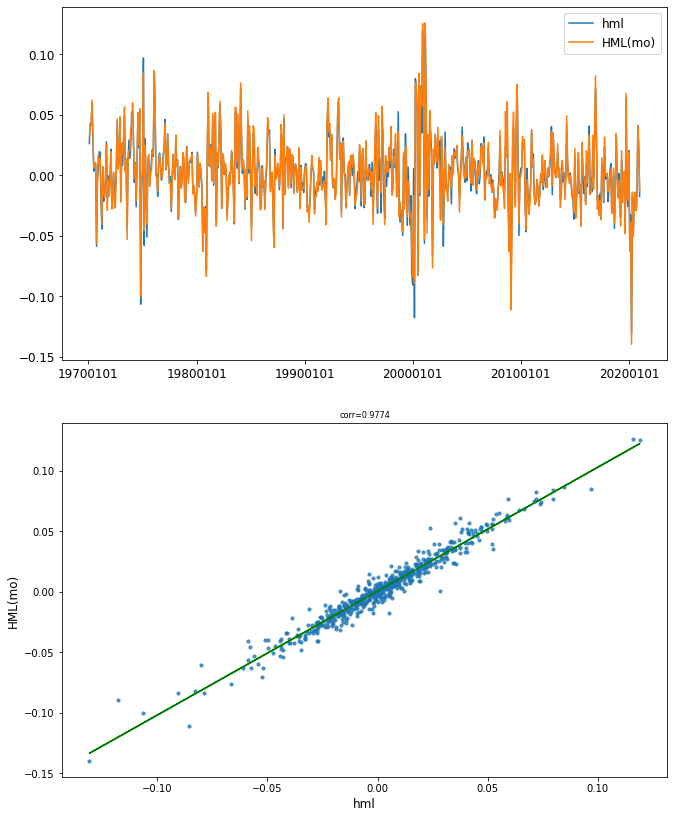

In [6]:
    label, benchname = 'hml', 'HML(mo)'
    holdings = portfolios['holdings'][label]
    result = backtest(crsp, holdings, label)
    y = backtest.fit([benchname], 19700101, LAST_DATE)
    plot_ff(y, label, corr=np.corrcoef(backtest.excess, rowvar=False)[0,1],
            num=1, logdir=logdir)

## Compare SMB 

- Construct portfolio returns and compare to retrieved benchmark

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:1200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.any(self._markerfacecolor != fc):


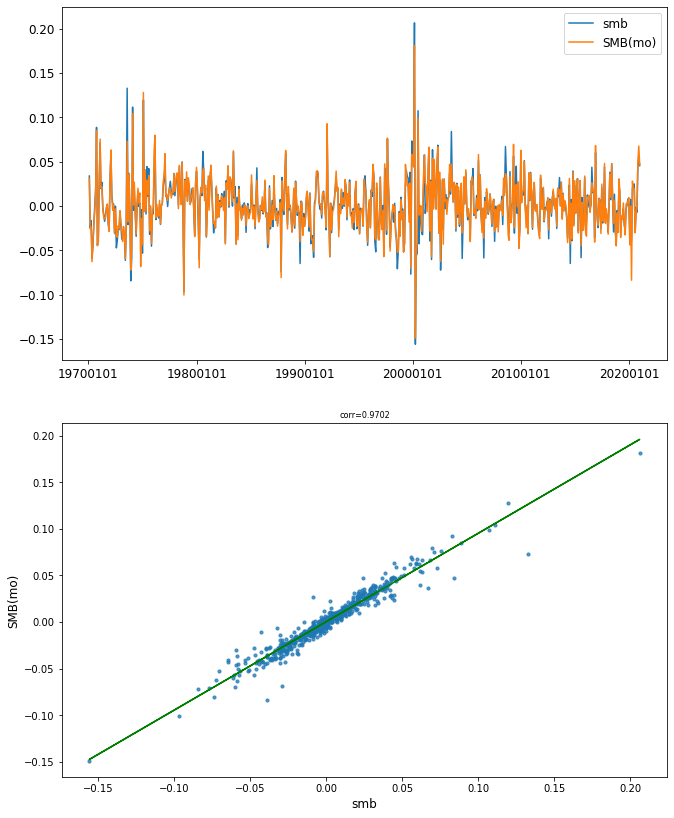

In [7]:
    label, benchname = 'smb', 'SMB(mo)'
    holdings = portfolios['holdings'][label]
    result = backtest(crsp, holdings, label)
    y = backtest.fit([benchname], 19700101, LAST_DATE)
    plot_ff(y, label, corr=np.corrcoef(backtest.excess, rowvar=False)[0,1],
            num=2, logdir=logdir)

## Construct Momentum and compare portfolio returns to retrieved benchmark

- Load monthly universe and stock returns from CRSP.
- Signal value is stocks' total return from 12 months ago, skipping most recent month
- Construct 2-way portfolio sorts, and backtest returns
- Compare to benchmark retrieved from Ken French's Dartmouth webside

In [8]:
    label, benchname, past, leverage = 'mom', 'Mom(mo)', (2,12), 1
    rebalbeg, rebalend = 19260101, LAST_DATE             

    # loop over each rebalance date to construct and collect signals values       
    df = []
    for rebaldate in bd.date_range(rebalbeg, rebalend, 'endmo'):
        beg = bd.endmo(rebaldate, -past[1])    # require price at this date           
        start = bd.offset(beg, 1)              # start date, inclusive, of signal     
        end = bd.endmo(rebaldate, 1-past[0])   # end date of signal  
        # Retrieve universe, require have prices at beg and end dates,            
        # and construct signal as returns compounded between start and end dates  
        p = [crsp.get_universe(rebaldate), # retrieve prices and construct signal     
             crsp.get_ret(start, end)['ret'].rename(label),
             crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
             crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end')]
        q = pd.concat(p, axis=1, join='inner').reset_index().dropna()
        q['rebaldate'] = rebaldate
        df.append(q[['permno','rebaldate',label]])
        #print(rebaldate, len(df), len(q))

    # Save signals values                                                         
    df = pd.concat(df)
    signals.write(df, label, overwrite=True)

3273743

In [9]:
    label, benchname, past, leverage = 'mom', 'Mom(mo)', (2,12), 1
    rebalbeg, rebalend = 19260101, LAST_DATE   
    
    # Construct holdings with 2-way sort, and evaluate backtest                   
    portfolios = famafrench_sorts(crsp, label, signals, rebalbeg, rebalend,
                                  window=0, months=[], leverage=leverage)

In [10]:
    holdings = portfolios['holdings'][label]
    result = backtest(crsp, holdings, label)
    y = backtest.fit([benchname])
    y

,mom,Mom(mo)
19270131,0.004128,0.0044
19270228,-0.021044,-0.0132
19270331,0.036642,0.0359
19270430,0.042850,0.0417
19270531,0.029773,0.0296
...,...,...
20200831,0.000247,0.0051
20200930,0.034812,0.0305
20201030,-0.034509,-0.0303
20201130,-0.119178,-0.1225


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:1200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.any(self._markerfacecolor != fc):


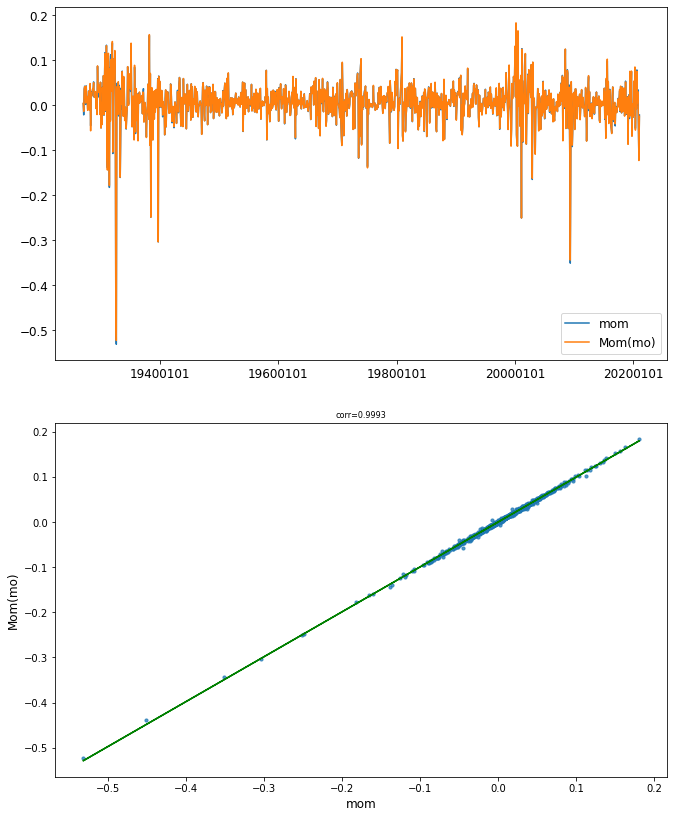

In [11]:
    plot_ff(y, label, corr=np.corrcoef(backtest.excess, rowvar=False)[0,1],
            num=3, logdir=logdir)

## Construct STRev portfolio returns and compare to retrieved benchmark

- Signal value is the negative of the most recent month's stock returns

In [12]:
    label, benchname, past, leverage = 'strev', 'ST_Rev(mo)', (1,1), -1
    rebalbeg, rebalend = 19260101, LAST_DATE               

    # loop over each rebalance date to construct and collect signals values       
    df = []
    for rebaldate in bd.date_range(rebalbeg, rebalend, 'endmo'):
        beg = bd.endmo(rebaldate, -past[1])   # beg price date of signal          
        end = bd.endmo(rebaldate, 1-past[0])  # end price date of signal          

        # Retrieve universe, require have prices at beg and end dates,            
        # and construct signal as returns compounded between start and end dates  
        p = [crsp.get_universe(rebaldate),
             crsp.get_section('monthly', 'prc', 'date', beg)['prc'].rename('beg'),
             crsp.get_section('monthly', 'prc', 'date', end)['prc'].rename('end'),
             crsp.get_ret(bd.offset(beg, 1), end).rename(columns={'ret': label})]
        q = pd.concat(p, axis=1, join='inner').reset_index().dropna()
        q['rebaldate'] = rebaldate
        df.append(q[['permno','rebaldate',label]])
        #print(rebaldate, len(df), len(q))

    # Save signals values                                                         
    df = pd.concat(df)
    signals.write(df, label, overwrite=True)

3559903

In [13]:
    # Construct holdings with 2-way sort, and evaluate backtest                   
    portfolios = famafrench_sorts(crsp, label, signals, rebalbeg, rebalend,
                                  window=0, months=[], leverage=leverage)

In [14]:
    holdings = portfolios['holdings'][label]
    result = backtest(crsp, holdings, label)
    y = backtest.fit([benchname])
    print(y.shape)

(1139, 2)


/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:1200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.any(self._markerfacecolor != fc):


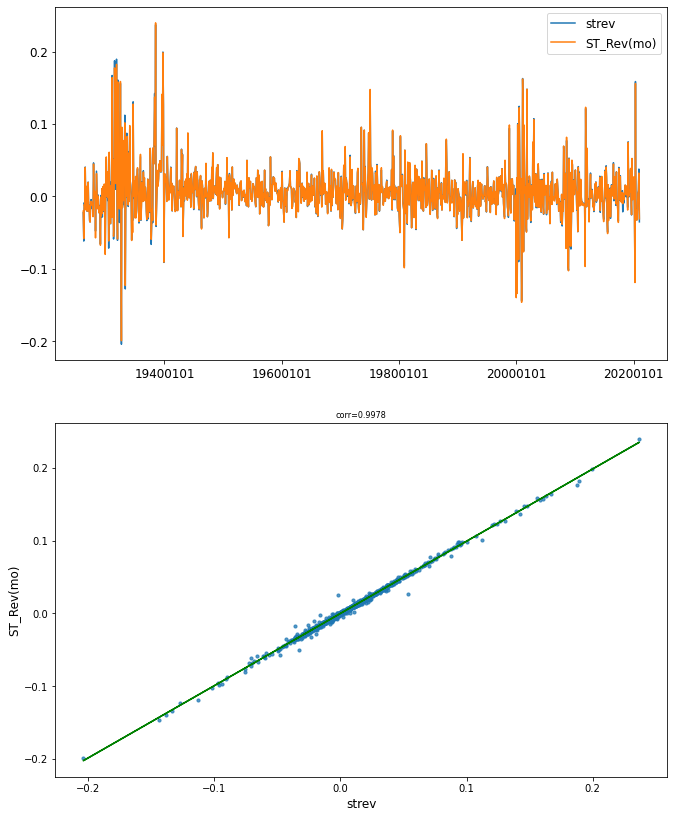

In [15]:
    plot_ff(y, label, corr=np.corrcoef(backtest.excess, rowvar=False)[0,1],
            num=4, logdir=logdir)